**Goal**: create a forecast of Madrid's electric demand

TODO: value counts na weather desc

In [93]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Preprocessing of data

In [134]:
energy_data = pd.read_csv('energy_dataset.csv')
weather_data = pd.read_csv('weather_features.csv')

energy_data.time = pd.to_datetime(energy_data.time).apply(lambda x: x.astimezone(timezone.utc))
energy_data = energy_data.set_index('time')

weather_data = weather_data[weather_data.city_name == 'Madrid'].copy()
weather_data.dt_iso = pd.to_datetime(weather_data.dt_iso).apply(lambda x: x.astimezone(timezone.utc))
weather_data = weather_data.set_index('dt_iso')
weather_data = weather_data.drop(columns='city_name')
weather_data = weather_data[~weather_data.index.duplicated()]
data = pd.merge(energy_data, weather_data, left_index=True, right_index=True)
data.index = pd.to_datetime(data.index.strftime("%Y-%m-%d %H:%M:%S"))

In [136]:
data.isnull().sum()[data.isnull().sum() > .1 * len(data)]

generation hydro pumped storage aggregated    35064
forecast wind offshore eday ahead             35064
dtype: int64

In [137]:
data.columns[data.any() == False]

Index(['generation fossil coal-derived gas', 'generation fossil oil shale',
       'generation fossil peat', 'generation geothermal',
       'generation hydro pumped storage aggregated', 'generation marine',
       'generation wind offshore', 'forecast wind offshore eday ahead'],
      dtype='object')

In [138]:
drop_cols_null = data.isnull().sum()[data.isnull().sum() > .1 * len(data)].index
drop_cols_zeros = data.columns[data.any() == False]
drop_cols = np.unique(np.concatenate((drop_cols_null, drop_cols_zeros)))
data = data.drop(columns=drop_cols)

In [139]:
data.isna().sum()[data.isna().sum() > 0]

generation biomass                             19
generation fossil brown coal/lignite           18
generation fossil gas                          18
generation fossil hard coal                    18
generation fossil oil                          19
generation hydro pumped storage consumption    19
generation hydro run-of-river and poundage     19
generation hydro water reservoir               18
generation nuclear                             17
generation other                               18
generation other renewable                     18
generation solar                               18
generation waste                               19
generation wind onshore                        18
total load actual                              36
dtype: int64

In [140]:
# splines of order 1
data = data.interpolate(method='slinear')

TODO: napisać ładniej

Demand for energy is not dependent on the source of generated energy, so we can create one columns in which there are summed up different generation sources.

In [141]:
generation_cols = data.columns[:14] 
data['total_generation'] = data[generation_cols].sum(axis=1)
data = data.drop(columns=generation_cols)
data = data[['total_generation'] + list(data.columns[:-1])]

Description of different columns:
datetime index localized to CET

city_name
name of city

temp
in k

temp_min
minimum in k

temp_max
maximum in k

pressure
pressure in hPa

humidity
humidity in %

wind_speed
wind speed in m/s

wind_deg
wind direction

rain_1h
rain in last hour in mm

rain_3h
rain last 3 hours in mm

snow_3h
show last 3 hours in mm

clouds_all
cloud cover in %

weather_id
Code used to describe weather

weather_main
Short description of current weather

weather_description
Long description of current weather

weather_icon
Weather icon code for website


In [142]:
data = data.drop(columns=['weather_id', 'weather_main', 'weather_icon', 'weather_description'])

Now we have to take care of categorical variables.

In [143]:
pd.options.display.max_rows = 100

In [144]:
len(data.iloc[:, -1:].value_counts())

88

In [145]:
data.dtypes

total_generation                   float64
forecast solar day ahead           float64
forecast wind onshore day ahead    float64
total load forecast                float64
total load actual                  float64
price day ahead                    float64
price actual                       float64
temp                               float64
temp_min                           float64
temp_max                           float64
pressure                             int64
humidity                             int64
wind_speed                           int64
wind_deg                             int64
rain_1h                            float64
rain_3h                            float64
snow_3h                            float64
clouds_all                           int64
dtype: object

We can use one-hot encoding, but 32 additional columns are too much

In [146]:
data

,total_generation,forecast solar day ahead,forecast wind onshore day ahead,total load forecast,total load actual,price day ahead,price actual,temp,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,rain_1h,rain_3h,snow_3h,clouds_all
time,,,,,,,,,,,,,,,,,,
2014-12-31 23:00:00,28251.0,17.0,6436.0,26118.0,25385.0,50.10,65.41,267.325,267.325,267.325,971,63,1,309,0.0,0.0,0.0,0
2015-01-01 00:00:00,27818.0,16.0,5856.0,24934.0,24382.0,48.10,64.92,267.325,267.325,267.325,971,63,1,309,0.0,0.0,0.0,0
2015-01-01 01:00:00,26796.0,8.0,5454.0,23515.0,22734.0,47.33,64.48,266.186,266.186,266.186,971,64,1,273,0.0,0.0,0.0,0
2015-01-01 02:00:00,25223.0,2.0,5151.0,22642.0,21286.0,42.27,59.32,266.186,266.186,266.186,971,64,1,273,0.0,0.0,0.0,0
2015-01-01 03:00:00,24620.0,9.0,4861.0,21785.0,20264.0,38.41,56.04,266.186,266.186,266.186,971,64,1,273,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-31 18:00:00,26415.0,96.0,3253.0,30619.0,30653.0,68.85,77.02,283.560,282.150,285.150,1030,88,1,280,0.0,0.0,0.0,0
2018-12-31 19:00:00,25213.0,51.0,3353.0,29932.0,29735.0,68.40,76.16,280.120,278.150,281.150,1031,52,1,260,0.0,0.0,0.0,0
2018-12-31 20:00:00,23987.0,36.0,3404.0,27903.0,28071.0,66.88,74.30,278.150,278.150,278.150,1030,65,1,340,0.0,0.0,0.0,0


# Data Visualization

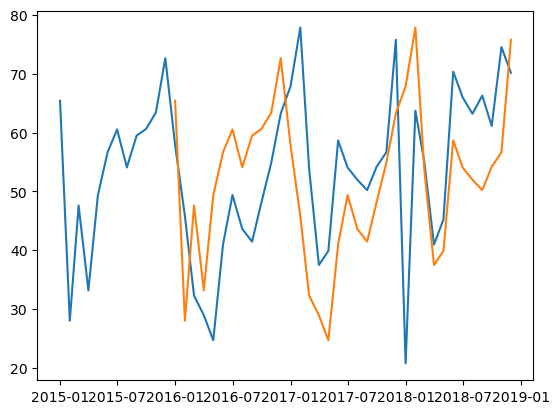

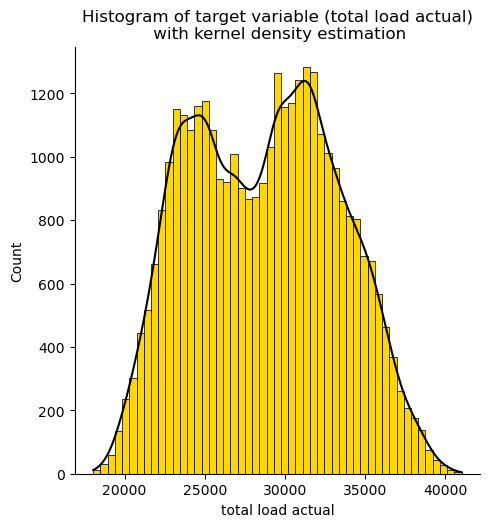

In [147]:
#plt.hist(data['total load actual'].values, bins=100, color='darkorange', histtype='bar')
sns.displot(data['total load actual'], kde=True, color='black', facecolor='gold')
plt.title('Histogram of target variable (total load actual)\n with kernel density estimation')
plt.show()

Bimodal distribution

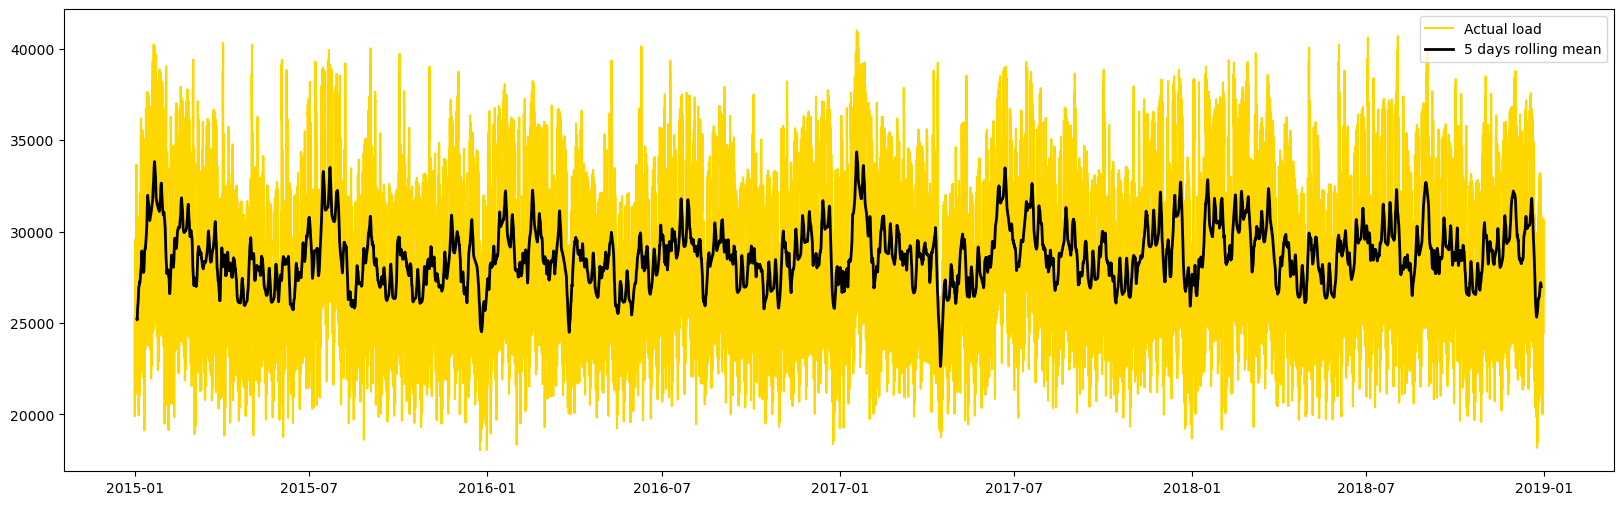

In [148]:
rolling = data['total load actual'].rolling(24*5, center = True).mean()
plt.figure(figsize=(20, 6))
plt.plot(data['total load actual'], color='gold', label='Actual load')
plt.plot(rolling, color = 'black', linestyle='-', linewidth=2, label='5 days rolling mean')
plt.legend()
plt.show()

In [149]:
X_cols = data.columns[:6].tolist() + data.columns[7:].tolist()
y_col = 'price actual'

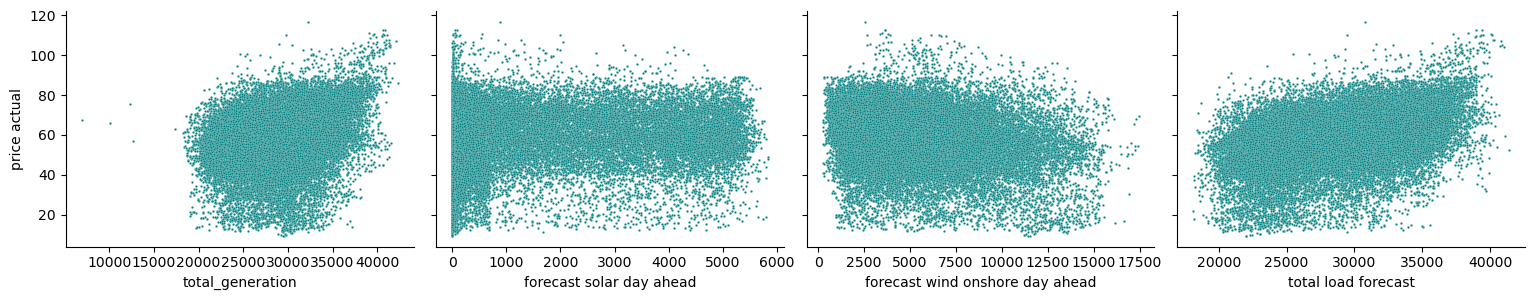

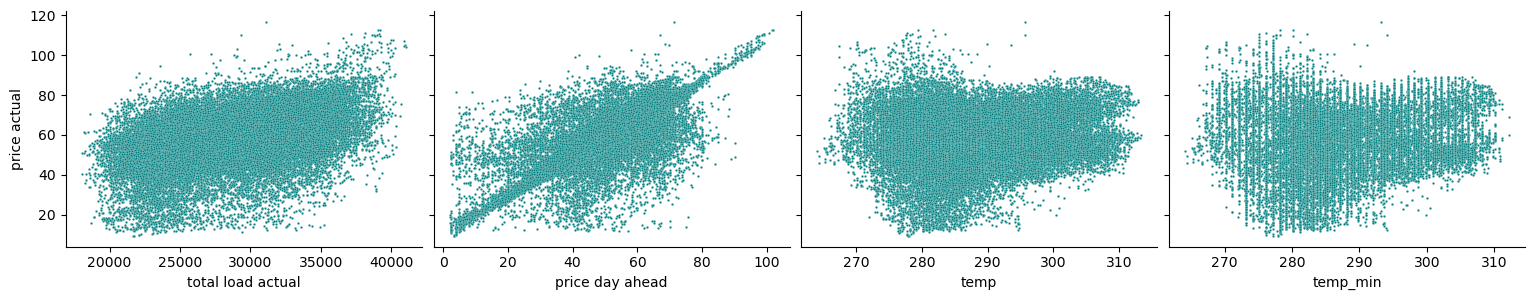

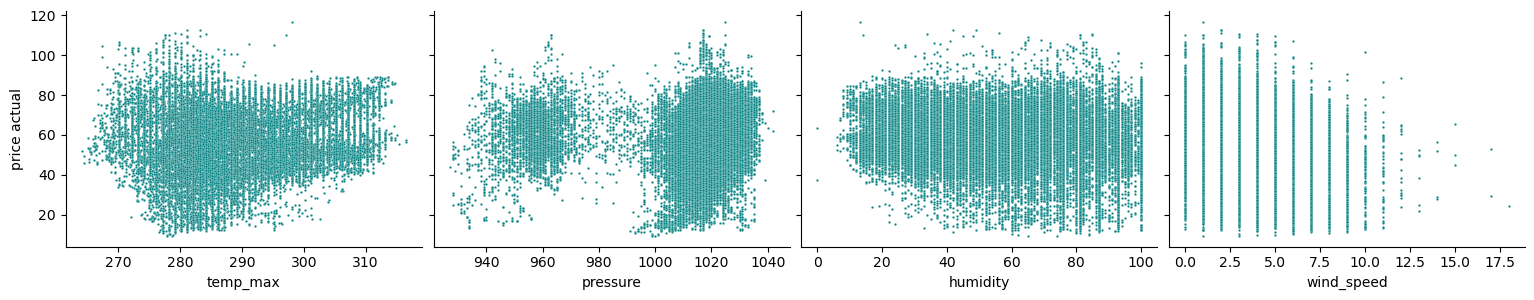

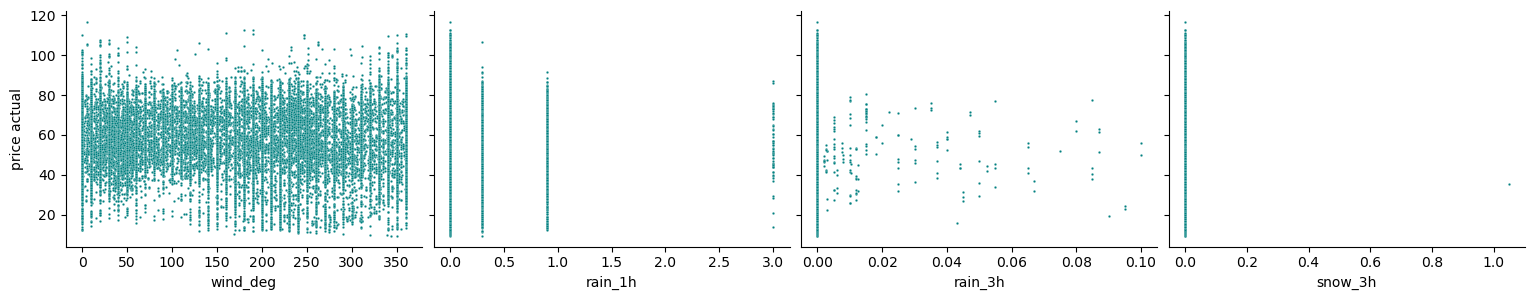

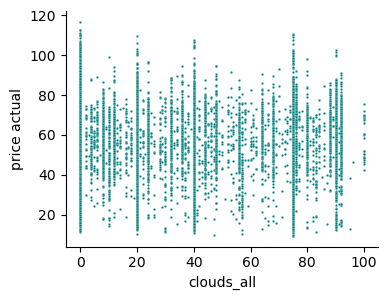

In [150]:
for i in range(5):
    aaa = sns.pairplot(data = data, x_vars=X_cols[4*i: 4*(i+1)], y_vars=y_col, height=3, aspect=1.3,  plot_kws={'s': 3, 'color': 'teal'})
    plt.show()

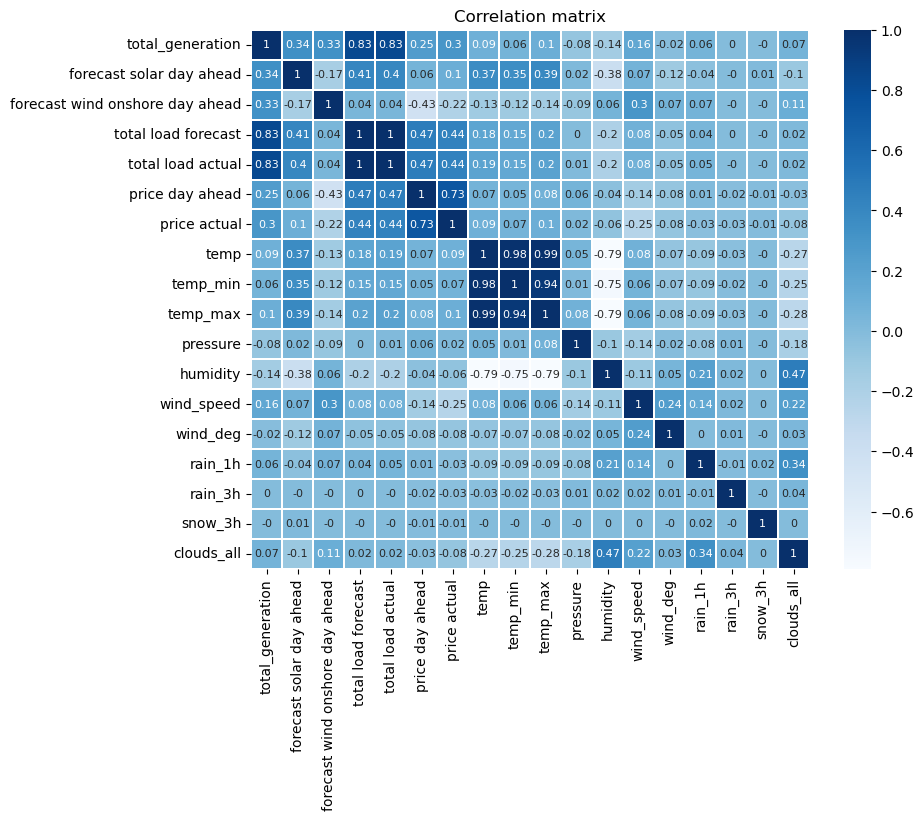

In [151]:
plt.figure(figsize=(9, 7))
sns.heatmap(round(data.corr(), 2), annot=True, cmap='Blues', linewidth=0.1, annot_kws={'fontsize': 8})
plt.title('Correlation matrix')
plt.show()

In [176]:
monthly_price

time
2014-12-31 23:00:00    65.41
2015-01-31 23:00:00    28.02
2015-02-28 23:00:00    47.60
2015-03-31 23:00:00    33.18
2015-04-30 23:00:00    49.32
2015-05-31 23:00:00    56.67
2015-06-30 23:00:00    60.52
2015-07-31 23:00:00    54.08
2015-08-31 23:00:00    59.48
2015-09-30 23:00:00    60.61
2015-10-31 23:00:00    63.39
2015-11-30 23:00:00    72.63
2015-12-31 23:00:00    57.85
2016-01-31 23:00:00    45.85
2016-02-29 23:00:00    32.29
2016-03-31 23:00:00    28.96
2016-04-30 23:00:00    24.70
2016-05-31 23:00:00    41.00
2016-06-30 23:00:00    49.38
2016-07-31 23:00:00    43.61
2016-08-31 23:00:00    41.46
2016-09-30 23:00:00    48.19
2016-10-31 23:00:00    54.88
2016-11-30 23:00:00    63.26
2016-12-31 23:00:00    67.85
2017-01-31 23:00:00    77.85
2017-02-28 23:00:00    53.88
2017-03-31 23:00:00    37.49
2017-04-30 23:00:00    39.89
2017-05-31 23:00:00    58.66
2017-06-30 23:00:00    54.05
2017-07-31 23:00:00    51.97
2017-08-31 23:00:00    50.21
2017-09-30 23:00:00    54.18
2017-10-3

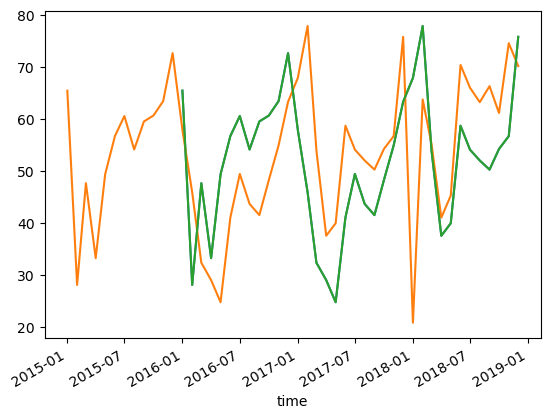

In [184]:
monthly_price = data['price actual'].asfreq('M')
lagged = monthly_price.shift(12).dropna()
fig, ax = plt.subplots(1,1)
lagged.plot()
ax.plot(monthly_price, label = 'Monthly Price')
ax.plot(lagged, label ='1 yr lagged')
plt.show()